# Introduction to Survival Analysis with Survival-NTF

**Survival-NTF** is a Python workflow for [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis) built on top of [scikit-survival](https://scikit-survival.readthedocs.io/en/stable/index.html) and [ism_pkg](tobedefined). It allows you to perform survival analysis using the power of scikit-survival and ism_pkg for identifying patterns of covariates and predicting survival.

Note: Parts of this tutorial have been taken from the [Introduction to Survival Analysis with scikit-survival](https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html) and [Penalized Cox Models](https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html)


## Table of Contents

1. [What is Survival Analysis?](#What-is-Survival-Analysis?)
2. [The Texco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data)
3. [Survival Data](#Survival-Data)
4. [The Survival Function](#The-Survival-Function)
5. [Multivariate Survival Models](#Multivariate-Survival-Models)
6. [Elastic Net](#Elastic-Net)
7. [Identifying Patterns of Covariates](#idenfifying-patterns-of-covariates)
8. [Measuring the Performance of Survival Models](#Measuring-the-Performance-of-Survival-Models)
9. [What's next?](#What's-next?)

## What is Survival Analysis?

The objective in survival analysis — also referred to as reliability analysis in engineering — is to establish a connection between covariates and the time of an event (or time-to-event). The name *survival analysis* originates from clinical research, where predicting the time to death, i.e., survival, is often the main objective. Survival analysis is a type of regression problem (one wants to predict a continuous value), but with a twist. It differs from traditional regression by the fact that parts of the training data can only be partially observed – they are *censored*.

As an example, consider a clinical study, which investigates coronary heart disease and has been carried out over a 1 year period as in the figure below.

![image censoring](https://k-d-w.org/clipboard/censoring.png)

Patient A was lost to follow-up after three months with no recorded cardiovascular event, patient B experienced an event four and a half months after enrollment, patient D withdrew from the study two months after enrollment, and patient E did not experience any event before the study ended. Consequently, the exact time of a cardiovascular event could only be recorded for patients B and C; their records are *uncensored*. For the remaining patients it is unknown whether they did or did not experience an event after termination of the study. The only valid information that is available for patients A, D, and E is that they were event-free up to their last follow-up. Therefore, their records are *censored*.

Formally, each patient record consists of a set of covariates $x \in \mathbb{R}^d$ , and the time $t>0$ when an event occurred or the time $c>0$ of censoring. Since censoring and experiencing and event are mutually exclusive, it is common to define an event indicator $\delta \in \{0;1\}$ and the observable survival time $y>0$. The observable time $y$ of a right censored sample is defined as

$$
y = \min(t, c) = 
\begin{cases} 
t & \text{if } \delta = 1 , \\ 
c & \text{if } \delta = 0 .
\end{cases}
$$

Consequently, survival analysis demands for models that take this unique characteristic of such a dataset into account, some of which are showcased below.

## The Telco Customer Churn

The [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data) includes information about 7043 customer:

- Customers who left within the last month
- Services that each customer has signed up for phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information: how long they've been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers: gender, age range, and if they have partners and dependents
Inspiration

Our primary interest is to predict behavior to retain customers.

As described in the section What is 'Survival Analysis?' above, survival times are subject to right-censoring, therefore, we need to consider an individual's status in addition to survival time. To be fully compatible with scikit-learn, `censor` and `time` need to be stored as a [structured array](https://numpy.org/doc/stable/user/basics.rec.html) with the first field `censor` indicating whether the actual survival time was observed or if was censored, and the second field  `time` denoting the observed survival time, which corresponds to the time of death.

In [1]:
# Install these additional packages in your environment
!pip install scikit-survival pyarrow fastparquet


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from utils_survival import load_ds2, load_dataset

x, y = load_dataset(7)
y

array([(False,  1.), (False, 34.), ( True,  2.), ..., (False, 11.),
       ( True,  4.), (False, 66.)],
      dtype=[('status', '?'), ('time', '<f8')])

In [3]:
print(x.index)

Index(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', '7795-CFOCW', '9237-HQITU',
       '9305-CDSKC', '1452-KIOVK', '6713-OKOMC', '7892-POOKP', '6388-TABGU',
       ...
       '9767-FFLEM', '0639-TSIQW', '8456-QDAVC', '7750-EYXWZ', '2569-WGERO',
       '6840-RESVB', '2234-XADUH', '4801-JZAZL', '8361-LTMKD', '3186-AJIEK'],
      dtype='object', name='CustomerId', length=7043)


In [4]:
import pandas as pd

# Check for missing values
# print(x.isnull())  # Returns a DataFrame of True/False values
print(x.isnull().sum())  # Counts missing values per column
print(x.isnull().sum().sum())  # Total missing values in entire DataFrame

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
dtype: int64
0


In [5]:
import pandas as pd
df = pd.read_parquet(r".\data\ds2.parquet")
print(df)

                        gender  SeniorCitizen Partner Dependents PhoneService  \
CustomerId Time Exited                                                          
7590-VHVEG 1    0       Female              0     Yes         No           No   
5575-GNVDE 34   0         Male              0      No         No          Yes   
3668-QPYBK 2    1         Male              0      No         No          Yes   
7795-CFOCW 45   0         Male              0      No         No           No   
9237-HQITU 2    1       Female              0      No         No          Yes   
...                        ...            ...     ...        ...          ...   
6840-RESVB 24   0         Male              0     Yes        Yes          Yes   
2234-XADUH 72   0       Female              0     Yes        Yes          Yes   
4801-JZAZL 11   0       Female              0     Yes        Yes           No   
8361-LTMKD 4    1         Male              1     Yes         No          Yes   
3186-AJIEK 66   0         Ma

We can easily see that many survival times are right-censored (`censor` is `False`), i.e., most customers did not switch operator during the study period.

## The Survival Function

A key quantity in survival analysis is the so-called survival function, which relates time to the probability of surviving beyond a given time point.

> Let $T$ denote a continuous non-negative random variable corresponding to a patient’s survival time. The survival function $S(t)$ returns the probability of survival beyond time $t$ and is defined as
> $$ S(t) = P (T > t). $$

Another key quantity is the hazard function, which is defined as the instantaneous risk that the event of interest happens, within a very narrow time frame.
> The hazard function formula is defined as:
> $$ h(t)=\frac{f(t)}{S{(t})} $$
> where $ f(t) $ is the probability density function of survival time $T$,

If we observed the exact survival time of all subjects, i.e., everyone died before the study ended, the survival function at time $t$ can simply be estimated by the ratio of patients surviving beyond time $t$ and the total number of patients:

$$
\hat{S}(t) = \frac{ \text{number of patients surviving beyond $t$} }{ \text{total number of patients} }
$$

When censoring exists, this estimator cannot be used because the numerator is not defined. Instead, the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) is commonly used.

## Cox Proportional Hazard Model

In the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator), multiple survival functions can be estimated by dividing the dataset into smaller sub-groups according to a variable. If we want to consider more than 1 or 2 variables, this approach quickly becomes infeasible, because subgroups will get very small. Instead, [Cox's proportional hazard's model](https://en.wikipedia.org/wiki/Proportional_hazards_model) can be used to assess the impact each variable has on a unique baseline survival curve estimated by the model.

> The hazard function for the Cox proportional hazards model has the form:
> $$ \begin{aligned}
\lambda\left(t \mid X_{i}\right) & =\lambda_{0}(t) \exp \left(\beta_{1} X_{i 1}+\cdots+\beta_{p} X_{i p}\right) \\
& =\lambda_{0}(t) \exp \left(X_{i} \cdot \beta\right)
\end{aligned} $$
> where $ X_{i}=\left(X_{i 1}, \ldots, X_{i p}\right) $ are the realized values of the $ p $ covariates for subject $ i $.

First however, we need to convert the categorical variables in the data set into numeric values.

In [6]:
from sksurv.preprocessing import OneHotEncoder

# x_numeric = OneHotEncoder().fit_transform(x)
x_numeric = pd.get_dummies(x, dtype=float)
x_numeric.head()

,SeniorCitizen,MonthlyCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
CustomerId,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,29.85,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5575-GNVDE,0,56.95,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3668-QPYBK,0,53.85,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7795-CFOCW,0,42.30,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9237-HQITU,0,70.70,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Survival models in **scikit-survival** follow the same rules as estimators in scikit-learn, i.e., they have a `fit` method, which expects a data matrix and a structured array of survival times and binary event indicators. Due to the high colinearity between covariates, we use the ridge regularization parameter `alpha=0.1` (we will return to this point soon).

In [7]:
from sklearn import set_config

from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis(alpha=0.1)
estimator.fit(x_numeric, y)

CoxPHSurvivalAnalysis(alpha=0.1)

The result is a vector of coefficients, one for each variable, where each value corresponds to the [log hazard ratio](https://en.wikipedia.org/wiki/Hazard_ratio).

In [8]:
import pandas as pd

pd.Series(estimator.coef_, index=x_numeric.columns)

SeniorCitizen                             -0.070336
MonthlyCharges                            -0.008924
gender_Female                              0.041422
gender_Male                               -0.041422
Partner_No                                 0.255852
Partner_Yes                               -0.255852
Dependents_No                              0.028518
Dependents_Yes                            -0.028518
PhoneService_No                           -0.022642
PhoneService_Yes                           0.022642
MultipleLines_No                           0.213790
MultipleLines_No phone service            -0.022642
MultipleLines_Yes                         -0.191148
InternetService_DSL                       -0.263699
InternetService_Fiber optic                0.329965
InternetService_No                        -0.066266
OnlineSecurity_No                          0.332184
OnlineSecurity_No internet service        -0.066266
OnlineSecurity_Yes                        -0.265918
OnlineBackup

### Elastic Net

[Cox's proportional hazard's model](https://en.wikipedia.org/wiki/Proportional_hazards_model) is often an appealing model, because its coefficients can be interpreted in terms of hazard ratio, which often provides valuable insight. However, if we want to estimate the coefficients of many features, the standard Cox model falls apart, because internally it tries to invert a matrix that becomes non-singular due to correlations among features.

### Ridge versus LASSO

This mathematical problem can be avoided by adding a $\ell_2$ penalty term on the coefficients that shrinks the coefficients to zero. While the $\ell_2$ (ridge) penalty does solve the mathematical problem of fitting a Cox model, we would still need to measure the expression levels of all 76 genes to make predictions. Ideally, we would like to select a small subset of features that are most predictive and ignore the remaining gene expression levels. This is precisely what the LASSO (Least Absolute Shrinkage and Selection Operator) penalty does. Instead of shrinking coefficients to zero it does a type of continuous subset selection, where a subset of coefficients are set to zero and are effectively excluded. This reduces the number of features that we would need to record for prediction. In mathematical terms, the $\ell_2$ penalty is replaced by a $\ell_1$ penalty, which leads to the optimization problem

The LASSO is a great tool to select a subset of discriminative features, but it has two main drawbacks. First, it cannot select more features than number of samples in the training data, which is problematic when dealing with very high-dimensional data. Second, if data contains a group of features that are highly correlated, the LASSO penalty is going to randomly choose one feature from this group. The Elastic Net penalty overcomes these problems by using a weighted combination of the $\ell_1$ and $\ell_2$ penalty by solving:

$$
\arg\max_{\beta}\quad\log \mathrm{PL}(\beta)
- \alpha
  \left( r \sum_{j=1}^p |\beta_j| + \frac{1 - r}{2} \sum_{j=1}^p \beta_j^2 \right) ,
$$

where $r \in [0; 1[$ is the relative weight of the $\ell_1$ and $\ell_2$ penalty. The Elastic Net penalty combines the subset selection property of the LASSO with the regularization strength of the Ridge penalty. This leads to better stability compared to the LASSO penalized model. For a group of highly correlated features, the latter would choose one feature randomly, whereas the Elastic Net penalized model would tend to select all. Usually, it is sufficient to give the $\ell_2$ penalty only a small weight to improve stability of the LASSO, e.g. by setting $r = 0.9$.

As for the LASSO, the weight $\alpha$ implicitly determines the size of the selected subset, and usually has to be estimated in a data-driven manner.

First, we divide the data into training and test parts. This allows us to evaluate the performance of the different models that are being tested.

In [9]:
from sklearn.model_selection import train_test_split

x_numeric, x_numeric_test, y, y_test = train_test_split(
    x_numeric,
    y,
    test_size=0.25,
    stratify=y["status"],
    random_state=0,
)

from utils_survival import (calculate_rss, normalize_with_coefficients)

normalization_coefficients = calculate_rss(x_numeric)
x_numeric = normalize_with_coefficients(x_numeric, normalization_coefficients)
x_numeric_test = normalize_with_coefficients(x_numeric_test, normalization_coefficients)

We apply [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to ensure that all variables are of the same scale during estimation. Next we determine the set of alphas which we want to evaluate (max_iter can be small for this purpose). Finally we perform 5 fold cross-validation to estimate the performance – in terms of concordance index – for each alpha. Again the result is a vector of coefficients, one for each variable, where each value corresponds to the [log hazard ratio](https://en.wikipedia.org/wiki/Hazard_ratio). Here we show only the non-zero coefficients.

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, KFold
import warnings
from sklearn.exceptions import FitFailedWarning

scaler_cox = StandardScaler()
scaler_cox.fit(x_numeric)
transformed_data = scaler_cox.transform(x_numeric)
x_numeric_scaled = pd.DataFrame(transformed_data, columns=x_numeric.columns)

def coxnet_regression(w_scaled, y):
    # determine the set of alphas which we want to evaluate (max_iter can be small for this purpose)
    l1_ratio = 0.9
    warnings.simplefilter("ignore", UserWarning)
    warnings.simplefilter("ignore", FitFailedWarning)
    coxnet_model = CoxnetSurvivalAnalysis(n_alphas=20, l1_ratio=l1_ratio, max_iter=100)
    coxnet_model.fit(w_scaled, y)
    estimated_alphas = coxnet_model.alphas_

    # perform 5 fold cross-validation to estimate the performance – in terms of concordance index – 
    # for each alpha
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    gcv = GridSearchCV(
        CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, fit_baseline_model=True, max_iter=1000),
        param_grid={"alphas": [[v] for v in estimated_alphas]},
        cv=cv,
        error_score=0.5,
        n_jobs=-1,
    ).fit(w_scaled, y)

    best_model = gcv.best_estimator_
    return best_model

coxnet_model = coxnet_regression(x_numeric_scaled.values, y)
selected_features = np.nonzero(coxnet_model.coef_)[0]
selected_features_coef = coxnet_model.coef_[selected_features].ravel()

pd.Series(selected_features_coef, index=x_numeric.columns[selected_features])

SeniorCitizen                             -0.033272
gender_Female                              0.053072
gender_Male                               -0.003669
Partner_No                                 0.239486
Partner_Yes                               -0.017115
Dependents_No                              0.038188
Dependents_Yes                            -0.003479
MultipleLines_No                           0.074329
MultipleLines_Yes                         -0.183371
InternetService_DSL                       -0.096279
InternetService_Fiber optic                0.089336
OnlineSecurity_No                          0.205222
OnlineSecurity_Yes                        -0.114420
OnlineBackup_No                            0.233789
OnlineBackup_Yes                          -0.099919
DeviceProtection_No                        0.048969
DeviceProtection_Yes                      -0.083015
TechSupport_No                             0.074948
TechSupport_Yes                           -0.147523
StreamingTV_

The coefficients can be visualized with their confidence intervals using the plot_forest function imported from utils_survival. First we calculate confidence intervals using the bootstrap_coxnet function also imported from utils_survival.

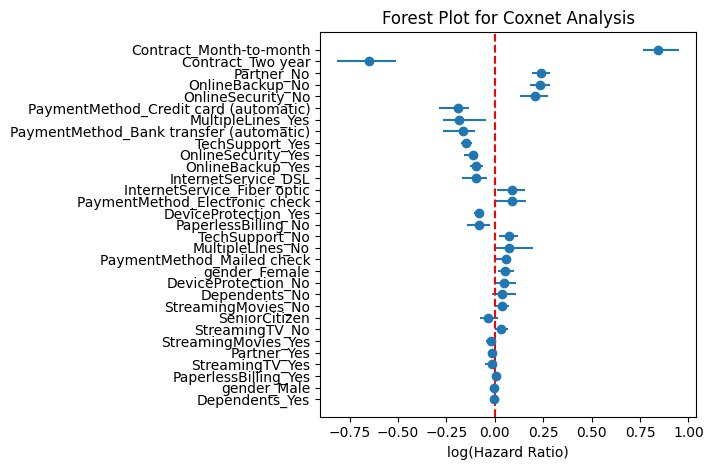

In [11]:
import copy
from utils_survival import plot_forest, bootstrap_coxnet

lower_conf_int, upper_conf_int = bootstrap_coxnet(coxnet_model, x_numeric_scaled.values, y, selected_features)
best_summary = list(zip(lower_conf_int, selected_features_coef, upper_conf_int))

plot_forest(best_summary, x_numeric_scaled.columns[selected_features])


## Idenfifying Patterns of Covariates

The model above returns hazard ratios related to each covariate individually. From this, we cannot infer which *patterns* of covariates are present in the data and investigate which pattern is the best risk predictor. To do this, we could perform dimensionality reduction using [Non-Negative Matrix Factorization (NMF)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF) or [Non-Negative Tensor Factorization (NTF)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF) before training a Cox model.

### NMF Patterns of Covariates

To estimate NMF patterns of covariates, we apply NMF to the $x$ matrix.
> `NMTF.fit_transform()` returns a dictionary with key `A` containing NTF components on each dimension of the tensor.
> 1. `A[0]` contains the loadings of the patients on each of the components and is noted `w`.
> 2. `A[1]` contains the loadings of the variables on each of the components and is noted`h`.

In [12]:
from enainem import EnAInem, _generate_tensor

# Meta-parameters
RANDOM_STATE =10
N_COMPONENTS = 3

nmtf = EnAInem(
    n_components=N_COMPONENTS,
    verbose=0,
    init="nndsvd",
    tol=1.0e-5,
    random_state=0,
    max_iter=200,
    target_polish=None,
)

result = nmtf.fit_transform(x_numeric.values)
w_nmf = result["B"][0]  # type: ignore
h_nmf = result["B"][1]  # type: ignore

Now let us look at the NMF patterns. For simplicity, we show only the top 10 covariates for each pattern.

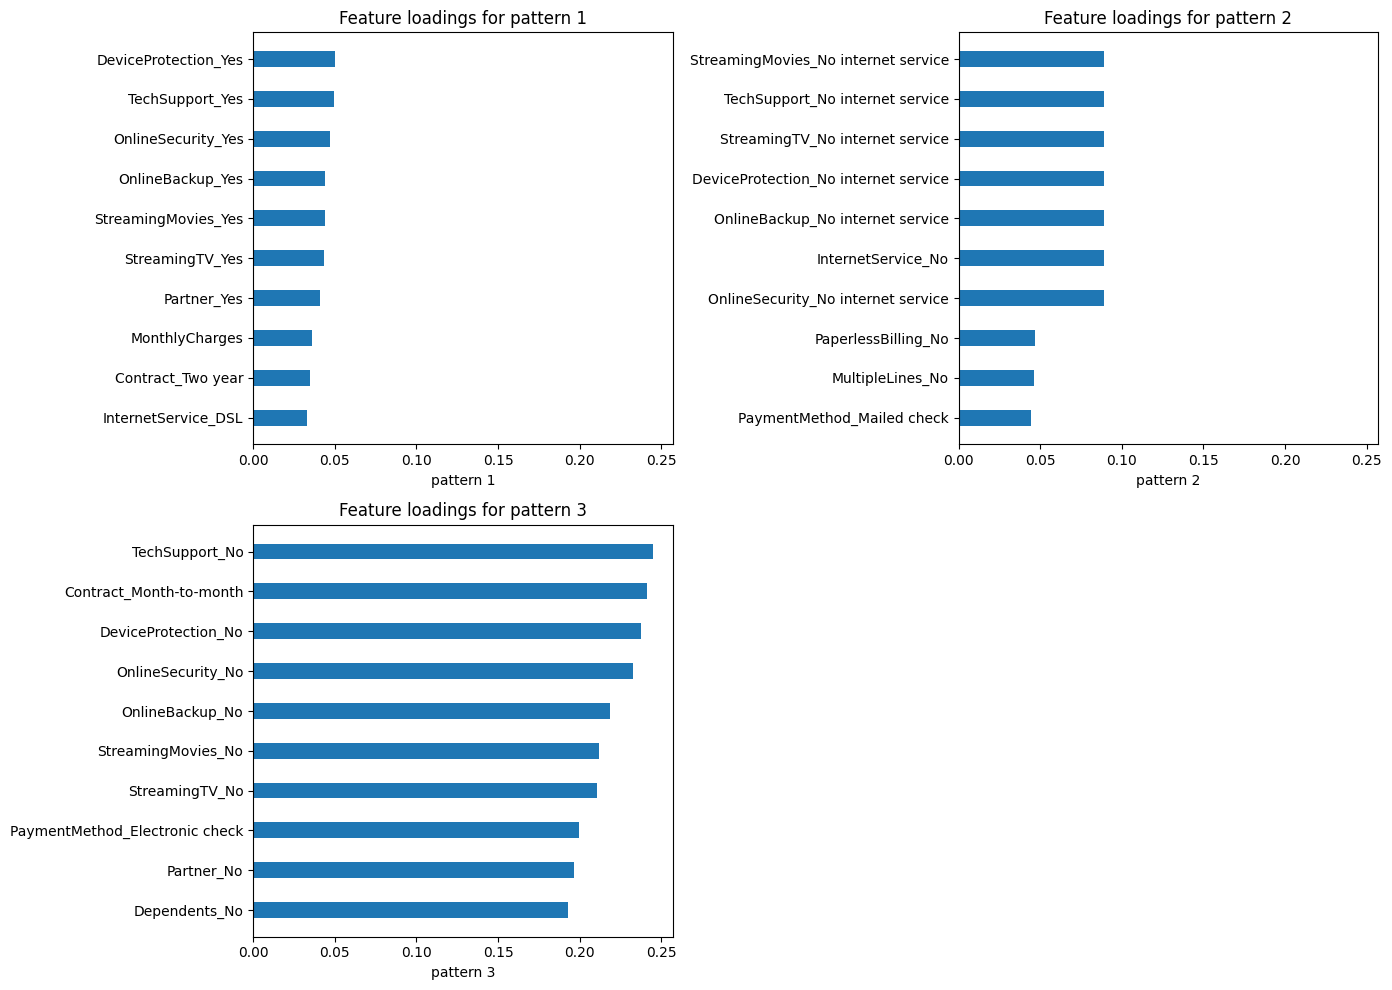

In [13]:
import matplotlib.pyplot as plt

new_df = pd.DataFrame(h_nmf)
new_df.rename(columns={col: 'pattern ' + str(col+1) for col in new_df.columns}, inplace=True) # type: ignore

# Insert the column names as the first column
new_df.insert(0, 'feature', x_numeric.columns)

num_columns = len(new_df.columns) - 1

# Calculate the number of rows needed (2 plots per row)
num_rows = (num_columns + 1) // 2

# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(14, 5 * num_rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plotting horizontal bar charts for each column
for i, column in enumerate(new_df.columns[1:]):
    sorted_df = new_df.sort_values(by=column, ascending=True)
    # sorted_df = sorted_df[sorted_df[column] > sorted_df[column].max()*.05]
    sorted_df = sorted_df.tail(10)
    axes[i].barh(sorted_df['feature'], sorted_df[column], height=0.4)
    axes[i].set_ylabel('')
    axes[i].set_xlabel(column)
    axes[i].set_xlim(h_nmf.min()*.95, h_nmf.max()*1.05)
    axes[i].set_title(f'Feature loadings for {column}')
    
# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


We can now apply Cox model to the data transformation.

In [14]:
# First we scale the NMF scores before training Cox model
scaler_nmf = StandardScaler()
scaler_nmf.fit(w_nmf)
w_scaled = scaler_nmf.transform(w_nmf)
coxnet_model_nmf_cox = coxnet_regression(w_scaled, y)
selected_features = np.nonzero(coxnet_model_nmf_cox.coef_)[0]
lower_conf_int, upper_conf_int = bootstrap_coxnet(coxnet_model_nmf_cox, w_scaled, y, selected_features)
selected_features_coef = coxnet_model_nmf_cox.coef_[selected_features].ravel()
best_summary = list(zip(lower_conf_int, selected_features_coef, upper_conf_int))


Now let us look at the hazard ratios of the components

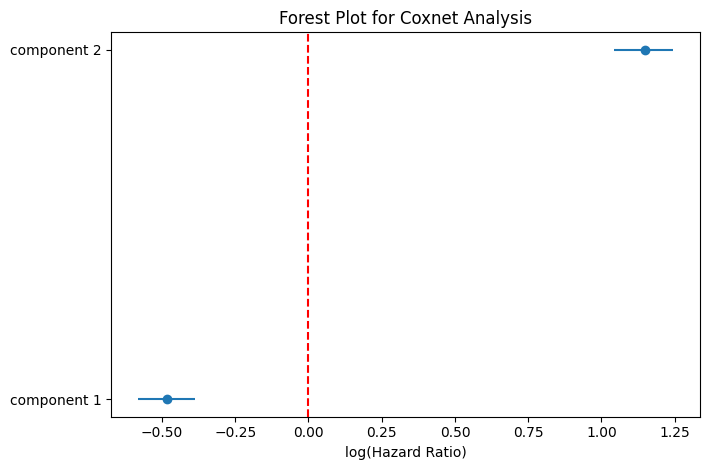

In [15]:
comp_period = np.array(['component ' + str(i+1) for i in range(N_COMPONENTS)])
plot_forest(best_summary, comp_period)


Note that all NMF components have negative log hazard ratios, which does not facilitate interpretation.

### NTF Patterns of Covariates

Unlike Non-Negative Matrix Factorization, which analyzes variables at baseline while ignoring survival information, we propose Non-Negative *Tensor* Factorization (NTF) to further allow pattern identification to be supervised by patient survival time. The idea is to divide patients into subgroups defined by the time period during which patients experience an event. First, we need to discretize survival days into a limited number of *time periods*, using common 10th, 25th, 50th, 75th, and 90th percentiles. 

In [16]:
PERCENTILES_BOUNDS = [10, 25, 50, 75, 90]
# Discretize survival_days
survival_days = y["time"]
# percentiles = np.percentile(y[y["status"] == True]["time"], PERCENTILES_BOUNDS)  # type: ignore
# print(percentiles)
percentiles = np.percentile(survival_days, PERCENTILES_BOUNDS)  # type: ignore
print(percentiles)
survival_days_discretized = np.digitize(survival_days, percentiles)

[ 2.  9. 29. 55. 69.]


#### Tensor initialization

We then initialize a tensor:
> $X \in \mathbb{R}^{n\times d\times q}$
> where $n=\text{number of patients}, d=\text{number of variables}, q=\text{number of periods}$.

The tensor is filled as follows:

> For each patient `i` and within each layer `k`, `X[i,:,k]` takes the values of $x(i)$ if the patient experienced an event within period $i$, otherwise it is set to 0.

Note that:
1. For censored subjects (whose event time is unknown), the corresponding entries of $X$ are set to 0 (to speed up the NTF analysis, these subjects are removed from $X$.)
2. When subjects are censored (e.g., drop out of a study or switch treatments), their data might be missing not at random, which can bias survival estimates. By accounting for the probability that a subject remains uncensored over time, using the inverse probability of censoring weights (IPCW), we remove the potential bias associated with censoring.

In [17]:
from sksurv.nonparametric import kaplan_meier_estimator

# Function to calculate the inverse probability of censoring weights
def ipcw(structured_data):
    # Estimate the Kaplan-Meier survival function for censoring times
    time, survival_prob = kaplan_meier_estimator(~structured_data["status"], structured_data["time"])  # type: ignore
    row_weights = np.sqrt(1 / np.interp(structured_data["time"], time, survival_prob))
    return row_weights

# Setup tensor of covariates using "supervized guess" to estimate ntf patterns
x_cens_0 = x_numeric.copy()
for i in range(x_cens_0.shape[0]):
    if not y[i][0]:
        x_cens_0.iloc[i] = 0

# Apply the Inverse Probability of Censoring Weights
weights_ipcw = ipcw(y)
x_cens_0 = x_cens_0.multiply(weights_ipcw, axis=0)

X = np.zeros((x_cens_0.shape[0], x_cens_0.shape[1], len(PERCENTILES_BOUNDS) + 1))  # type: ignore
for i in range(X.shape[0]):
    X[i, :, survival_days_discretized[i]] = x_cens_0.iloc[i]

# Replace nan values by zeros (in effect cancelling the tensor row)
X = np.where(np.isnan(X), 0, X)

# To speed up the NTF analysis, these subjects are removed from $X$.
rows_with_non_zero = np.any(x_cens_0 != 0, axis=1)
X = X[rows_with_non_zero, :, :]

#### Applying NTF

Next, we apply NTF to the tensor $X$ to identify patterns of $x$ covariates supervized by event time. For now, the number of components `n_components`is set to 3 as with NMF. This number can be optimized in subsequent steps, as we will be discussed later.

> `NMTF.fit_transform()` returns a dictionary with key `A` containing NTF components on each dimension of the tensor.
> 1. `B[0]` contains the loadings of the patients on each of the components and is noted `w`.
> 2. `B[1]` contains the loadings of the variables on each of the components and is noted`h`.
> 3. `B[2]` contains the loadings of the periods on each of the components and is noted `q`.

In [18]:
nmtf = EnAInem(
    n_components=N_COMPONENTS,
    verbose=0,
    init="random",
    tol=1.0e-5,
    random_state=1,
    max_iter=200,
    target_polish=None,
)

# First estimation using only non-censored observations
result = nmtf.fit_transform(X)
w_ntf = result["B"][0]  # type: ignore
h_ntf = result["B"][1]  # type: ignore
q_ntf = result["B"][2]  # type: ignore


Now let us look at the NTF patterns.

We first order the NTF components by the increasing value of their associated period. This is defined by the index of the highest value found in the corresponding `q` components. For simplicity, we show only the top 10 covariates for each pattern.

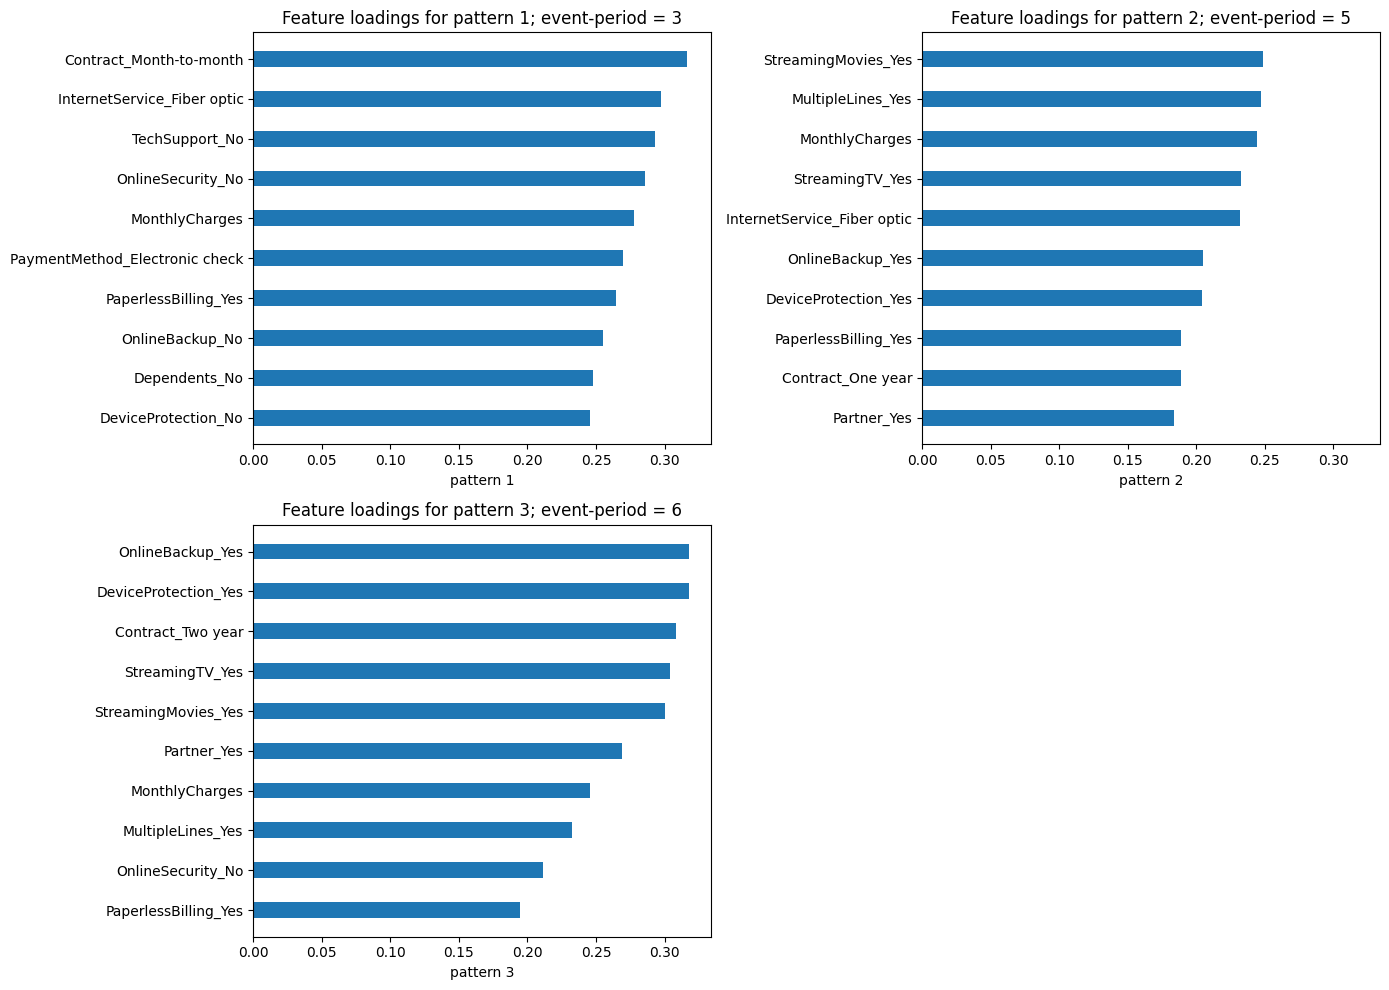

In [19]:
import matplotlib.pyplot as plt

event_period = np.argmax(q_ntf, axis=0)
ranked_components = np.argsort(event_period)
w_ntf = w_ntf[:, ranked_components]
h_ntf = h_ntf[:, ranked_components]
q_ntf = q_ntf[:, ranked_components]
event_period = event_period[ranked_components]

new_df = pd.DataFrame(h_ntf)
new_df.rename(columns={col: 'pattern ' + str(col+1) for col in new_df.columns}, inplace=True) # type: ignore

# Insert the column names as the first column
new_df.insert(0, 'feature', x_numeric.columns)

num_columns = len(new_df.columns) - 1

# Calculate the number of rows needed (2 plots per row)
num_rows = (num_columns + 1) // 2

# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(14, 5 * num_rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plotting horizontal bar charts for each column
for i, column in enumerate(new_df.columns[1:]):
    sorted_df = new_df.sort_values(by=column, ascending=True)
    # sorted_df = sorted_df[sorted_df[column] > sorted_df[column].max()*.05]
    sorted_df = sorted_df.tail(10)
    axes[i].barh(sorted_df['feature'], sorted_df[column], height=0.4)
    axes[i].set_ylabel('')
    axes[i].set_xlabel(column)
    axes[i].set_xlim(h_ntf.min()*.95, h_ntf.max()*1.05)
    axes[i].set_title(f'Feature loadings for {column}; event-period = {event_period[i]+1}')
    
# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Applying Cox model to the data transformation

Bearing in mind that the way the tensor $X$ was set was supervized - so the NTF transformation `w` directly benefited from this valuable information - how can we *predict* survival when the time-to-event information is not known, as in real life?

#### Constructing a *Cox-derived* tensor

When constructing the tensor $X$, we used the known time-to-event for each uncensored patient to select the correct layer/period to fill with the appropriate covariate values. Other layers were left with 0 values. This time, we use a more *naive* scheme by filling *each* layer/period with each patient's covariate values, weighted by that patient's probability of experiencing the event in that period. This probability is derived from the Cox model. We do that for patients in both train and test parts of the dataset.

In [20]:
# Predict the survival function for the specific patient
survival_function = coxnet_model.predict_survival_function(x_numeric_scaled.values)
weights = np.zeros((x_numeric.shape[0], len(percentiles) + 1))

for i in range(x_numeric.shape[0]):
    survival_at_t = np.array(
        [survival_function[i](percentiles[j]) for j in range(len(percentiles))]
    )
    survival_at_t_minus_1 = np.insert(survival_at_t, 0, 1)
    survival_at_t = np.append(survival_at_t, 0)
    # Calculate the hazard probability in each period
    weights[i, :] = np.sqrt(survival_at_t_minus_1 - survival_at_t)  # type: ignore

# Create weighted tensor
X = np.zeros((x_numeric.shape[0], x_numeric.shape[1], len(percentiles) + 1))
for j in range(len(percentiles) + 1):
    X[:, :, j] = weights[:, j, np.newaxis] * x_numeric.values

transformed_data = scaler_cox.transform(x_numeric_test)
x_numeric_test_scaled = pd.DataFrame(transformed_data, columns=x_numeric_test.columns)

survival_function = coxnet_model.predict_survival_function(x_numeric_test_scaled.values)
weights_test = np.zeros((x_numeric_test.shape[0], len(percentiles) + 1))

for i in range(x_numeric_test.shape[0]):
    survival_at_t = np.array(
        [survival_function[i](percentiles[j]) for j in range(len(percentiles))]
    )
    survival_at_t_minus_1 = np.insert(survival_at_t, 0, 1)
    survival_at_t = np.append(survival_at_t, 0)
    # Calculate the hazard probability in each period
    weights_test[i, :] = np.sqrt(survival_at_t_minus_1 - survival_at_t)  # type: ignore

# Create weighted tensor
X_test = np.zeros((x_numeric_test.shape[0], x_numeric_test.shape[1], len(percentiles) + 1))
for j in range(len(percentiles) + 1):
    X_test[:, :, j] = weights_test[:, j, np.newaxis] * x_numeric_test.values


#### Applying NTF again, this time to the new tensor

The idea is that we can still take advantage of the`h` and `q` components found in the first NTF, which we have obtained through our time-to-event supervised learning, with the help of the following scheme:
1. Apply NTF to the weighted tensor, this time with `h` and `q` *fixed*.
2. Apply `StandardScaler()` to the updated `w`.
3. Estimate Cox model parameters using the updated `w`.

In [21]:
nmtf.init = "custom"

result = nmtf.fit_transform(
    X,
    B=[np.ones((X.shape[0], N_COMPONENTS)), h_ntf, q_ntf],
    update=[True, False, False],
)
w_ntf = result["B"][0]  # type: ignore

scaler_ntf = StandardScaler()
scaler_ntf.fit(w_ntf)
w_scaled = scaler_ntf.transform(w_ntf)
coxnet_model_ntf_cox = coxnet_regression(w_scaled, y)
selected_features = np.nonzero(coxnet_model_ntf_cox.coef_)[0]
lower_conf_int, upper_conf_int = bootstrap_coxnet(coxnet_model_ntf_cox, w_scaled, y, selected_features)
selected_features_coef = coxnet_model_ntf_cox.coef_[selected_features].ravel()
best_summary = list(zip(lower_conf_int, selected_features_coef, upper_conf_int))


Now let us look at the hazard ratios of the components

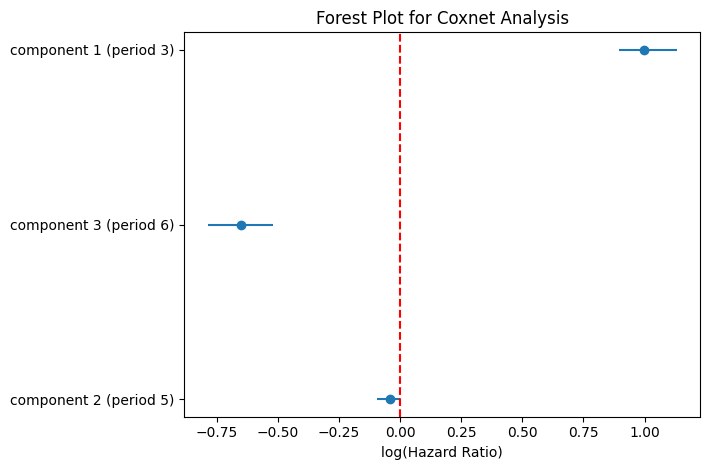

In [22]:
comp_period = np.array(['component ' + str(i+1) + ' (period ' + str(event_period[i]+1) +')' for i in range(N_COMPONENTS)])
plot_forest(best_summary, comp_period)


## Measuring the Performance of Survival Models

Once we fit a survival model, we usually want to assess how well a model can actually predict survival. Our test data is usually subject to censoring too, therefore metrics like root mean squared error or correlation are unsuitable. Instead, we use generalization of the area under the receiver operating characteristic (ROC) curve called [Harrell's concordance index](https://pdfs.semanticscholar.org/7705/392f1068c76669de750c6d0da8144da3304d.pdf) or c-index.

The interpretation is identical to the traditional area under the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) metric for binary classification:
- a value of 0.5 denotes a random model,
- a value of 1.0 denotes a perfect model,
- a value of 0.0 denotes a perfectly wrong model.

### Performance of Cox Model

We will use the scikit-surv score method and apply it to the test part of the dataset.

In [23]:
# We used the scaled test part of the dataset.
coxnet_model_score = coxnet_model.score(x_numeric_test_scaled, y_test)
print(f"coxnet_model_score = {round(coxnet_model_score, 2)}")

coxnet_model_score = 0.86


Our model's c-index (0.86) indicates that the model clearly performs better than random.

### Performance of NMF-Cox Model

First we have to estimate the NMF scores on the test part of the data.

In [24]:
nmtf.init = "custom"

result = nmtf.fit_transform(
    x_numeric_test.values,
    B=[np.ones((x_numeric_test.shape[0], N_COMPONENTS)), h_nmf],
    update=[True, False],
)
w_test = result["B"][0]  # type: ignore
# We used the scaled test part of the dataset.
w_test_scaled = scaler_nmf.transform(w_test)

We can now calculate Harrel's concordance index on the test part of the dataset.

In [25]:
coxnet_model_nmf_cox_score = coxnet_model_nmf_cox.score(w_test_scaled, y_test)
print(f"coxnet_model_nmf_cox_score = {round(coxnet_model_nmf_cox_score, 2)}")

coxnet_model_nmf_cox_score = 0.82


The Harrel's concordance index is now 0.82, which is slightly smaller than 0.86 achieved by the Cox analysis performed directly on the variables.

### Performance of NTF-Cox Model

First we have to estimate the NTF scores on the test part of the data.

In [26]:
result = nmtf.fit_transform(
    X_test,
    B=[np.ones((X_test.shape[0], N_COMPONENTS)), h_ntf, q_ntf],
    update=[True, False, False],
)
w_test = result["B"][0]  # type: ignore
w_test_scaled = scaler_ntf.transform(w_test)

We can now calculate Harrel's concordance index on the test part of the dataset.

In [27]:
coxnet_model_ntf_cox_score = coxnet_model_ntf_cox.score(w_test_scaled, y_test)
print(f"coxnet_model_ntf_cox_score = {round(coxnet_model_ntf_cox_score, 2)}")

coxnet_model_ntf_cox_score = 0.84


The Harrel's concordance index is again 0.84, which is slightly smaller than 0.86 achieved by the Cox analysis performed directly on the variables.